<h1 style="text-align: center;">Experiment-7</h1>
<h1 style="text-align: center;">Local Outlier Factors</h1>

## **Problem Statement**
In many real world applications, identifying anomalous or unusual observation is critical, such as, in fraud detection, intrusion detection in networks and medical diagnosis. The LOF algorithm is a popular unsupervied technique for detecting anomalies by comparing the local density of a datapoint with that of its neighbours. <br> In this experiment, we will apply the LOF method on synthetic or real-world datasets to identify aoutliers and interpret their significance.

## **Objectives**
1. Understand the concept and mathematical intuition behind the Local Outlier Factor
2. Implement LOF using python and skicit-learn
3. Visualize how LOF distinguishes normal datapoints from anomalies
4. Evaluate the performance of LOF on a real-world dataset
5. Interpret the significance of outliers in the context of dataset used

## **Task Outline:**

1. Load and preprocess a dataset (e.g., Iris, Breast Cancer, or a custom credit card fraud dataset).
2. Normalize the dataset.
3. Use the sklearn.neighbors.LocalOutlierFactor module to apply LOF.
4. Identify the outliers and visualize them using scatter plots or pair plots.
5. Analyze the anomaly scores and explain which points are considered outliers and why.
6. Compare LOF with other anomaly detection algorithms like One-Class SVM or Isolation Forest (optional extension).

## **Local Outlier Factors**
LOF is a density-based algorithm that detects anomalies by comparing the local density of a data point with that of its neighbors. 

Here's the intuition:

1. For each point, LOF calculates how isolated it is relative to its surrounding neighbors
2. Points in dense regions have local densities similar to their neighbors
3. Anomalies tend to lie in less dense regions, having significantly lower local density than their neighbors

### **The key steps in the LOF algorithm are:**

1. Calculate the k-distance for each point (distance to its kth nearest neighbor)
2. Compute the reachability distance between points
3. Determine the local reachability density of each point
4. Calculate the final LOF score as the ratio of average local reachability density of neighbors to the point's own density

Let's implement this using Python and scikit-learn.

### **LOF Mathematical Intuition in Detail**

1. **K-distance:** For each data point p, find the distance to its k-nearest neighbor. This value is called k-distance(p).
   
2. **Reachability distance:** For two points p and o, the reachability distance is defined as: <br>
   `reach-dist_k(p, o) = max(k-distance(o), distance(p, o))`
   
3. **Local reachability density (LRD):** The inverse of the average reachability distance of a point p to its k-nearest neighbors: <br>
    `lrd_k(p) = 1 / (average reach-dist_k(p, o) for all o in k-NN(p))`
   
4. **Local Outlier Factor:** The LOF of a point p is the average ratio of the LRD of p's neighbors to the LRD of p itself: <br>
    `LOF_k(p) = average(lrd_k(o) / lrd_k(p) for all o in k-NN(p))`

## **Implementation with Python**

### **Dataset description**

The **Iris** dataset is used for this project. This dataset is one of the most famous datasets in pattern recognition and machine learning.

**Dataset Details:**
**Type:** Tabular dataset (numeric measurements)

**Features:** 4 numeric attributes

- Sepal length (cm)
- Sepal width (cm)
- Petal length (cm)
- Petal width (cm)

**Number of Classes:** 3 (Iris species)

- Iris Setosa (50 samples)
- Iris Versicolor (50 samples)
- Iris Virginica (50 samples)

**Number of Classes:** 10 (Digits from 0 to 9)

**Format:** Each record represents measurements of an individual iris flower

**Creator:** R.A. Fisher (1936)

**Characteristics:** The dataset is notable because Iris Setosa is linearly separable from the other two species, while Versicolor and Virginica have some overlap, making it ideal for demonstrating both classification and clustering algorithms.

This dataset is particularly suitable for anomaly detection experiments as it contains natural clusters with different densities and some boundary cases that could be identified as anomalies by density-based algorithms like LOF.

### **Importing necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

### **Loading dataset for anomaly detection (iris, breast_cancer, or synthetic)**

In [3]:
def load_dataset(dataset_name='iris'):
    """
    Load a dataset for anomaly detection
    
    Parameters:
    dataset_name (str): Name of the dataset to load ('iris', 'breast_cancer', or 'synthetic')
    
    Returns:
    X (numpy.ndarray): Features
    y (numpy.ndarray): Labels (only used for evaluation)
    feature_names (list): Names of features
    """
    if dataset_name == 'iris':
        data = load_iris()
        X = data.data
        y = data.target
        feature_names = data.feature_names
        
    elif dataset_name == 'breast_cancer':
        data = load_breast_cancer()
        X = data.data
        y = data.target
        feature_names = data.feature_names
        
    elif dataset_name == 'synthetic':
        # Create a synthetic dataset with obvious outliers
        n_samples = 300
        n_outliers = 15
        n_features = 2
        
        # Generate normal points
        X = np.random.randn(n_samples - n_outliers, n_features)
        # Add cluster structure
        X[:100, 0] += 5
        X[:100, 1] += 5
        X[100:200, 0] += 10
        
        # Generate outliers
        outliers = np.random.uniform(low=-4, high=14, size=(n_outliers, n_features))
        X = np.vstack([X, outliers])
        
        # Generate fake labels (0 for normal, 1 for outliers)
        y = np.zeros(n_samples)
        y[-n_outliers:] = 1
        
        feature_names = [f'Feature {i+1}' for i in range(n_features)]
    
    return X, y, feature_names

### **Normalize the dataset using StandardScaler**

In [4]:
def preprocess_data(X):
    """
    Normalize the dataset using StandardScaler
    
    Parameters:
    X (numpy.ndarray): Input features
    
    Returns:
    X_scaled (numpy.ndarray): Normalized features
    scaler (StandardScaler): Fitted scaler object
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

### **Apply Local Outlier Factor to detect anomalies**

In [5]:
def apply_lof(X, n_neighbors=20, contamination=0.1):
    """
    Apply Local Outlier Factor to detect anomalies
    
    Parameters:
    X (numpy.ndarray): Input features
    n_neighbors (int): Number of neighbors to consider
    contamination (float): Expected proportion of outliers in the dataset
    
    Returns:
    y_pred (numpy.ndarray): Predicted labels (-1 for outliers, 1 for inliers)
    lof_scores (numpy.ndarray): Negative outlier factor of each sample
    """
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    y_pred = clf.fit_predict(X)
    
    # Get the negative outlier factor (higher values indicate more outlier-ness)
    lof_scores = -clf.negative_outlier_factor_
    
    return y_pred, lof_scores

### **Visualize outliers in a 2D scatter plot**

In [6]:
def visualize_outliers_2d(X, y_pred, lof_scores, feature_names, title="LOF Anomaly Detection"):
    """
    Visualize outliers in a 2D scatter plot
    
    Parameters:
    X (numpy.ndarray): Input features
    y_pred (numpy.ndarray): Predicted labels from LOF
    lof_scores (numpy.ndarray): LOF scores
    feature_names (list): Names of features
    title (str): Plot title
    """
    plt.figure(figsize=(12, 10))
    
    # If more than 2 dimensions, use PCA to reduce to 2D
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
        x_label = "PCA Component 1"
        y_label = "PCA Component 2"
    else:
        X_2d = X
        x_label = feature_names[0]
        y_label = feature_names[1]
    
    # Create scatter plot
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=lof_scores, 
                          cmap='viridis', alpha=0.8, s=100, edgecolors='k')
    
    # Highlight outliers with red circles
    outliers = y_pred == -1
    plt.scatter(X_2d[outliers, 0], X_2d[outliers, 1], 
                s=200, edgecolors='r', facecolors='none', linewidths=2, label='Outliers')
    
    plt.colorbar(scatter, label='LOF Score (higher = more anomalous)')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


### **Visualize outliers in a 3D scatter plot**

In [7]:
def visualize_outliers_3d(X, y_pred, lof_scores, feature_names):
    """
    Visualize outliers in a 3D scatter plot
    
    Parameters:
    X (numpy.ndarray): Input features
    y_pred (numpy.ndarray): Predicted labels from LOF
    lof_scores (numpy.ndarray): LOF scores
    feature_names (list): Names of features
    """
    if X.shape[1] < 3:
        print("Dataset has fewer than 3 dimensions. Using 2D visualization instead.")
        visualize_outliers_2d(X, y_pred, lof_scores, feature_names)
        return
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # If more than 3 dimensions, use PCA to reduce to 3D
    if X.shape[1] > 3:
        pca = PCA(n_components=3)
        X_3d = pca.fit_transform(X)
        x_label = "PCA Component 1"
        y_label = "PCA Component 2"
        z_label = "PCA Component 3"
    else:
        X_3d = X
        x_label = feature_names[0]
        y_label = feature_names[1]
        z_label = feature_names[2]
    
    # Create scatter plot
    scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], 
                          c=lof_scores, cmap='viridis', alpha=0.8, s=50)
    
    # Highlight outliers with red circles
    outliers = y_pred == -1
    ax.scatter(X_3d[outliers, 0], X_3d[outliers, 1], X_3d[outliers, 2], 
                s=100, edgecolors='r', facecolors='none', linewidths=2, label='Outliers')
    
    plt.colorbar(scatter, label='LOF Score (higher = more anomalous)')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title("LOF Anomaly Detection in 3D")
    plt.legend()
    plt.tight_layout()
    plt.show()

### **Analyze the distribution of LOF scores**

In [8]:
def analyze_lof_scores(lof_scores, y_pred):
    """
    Analyze the distribution of LOF scores
    
    Parameters:
    lof_scores (numpy.ndarray): LOF scores
    y_pred (numpy.ndarray): Predicted labels
    """
    plt.figure(figsize=(10, 6))
    
    # Create histogram of LOF scores
    plt.hist(lof_scores, bins=50, alpha=0.7)
    
    # Add vertical line for the threshold
    outlier_scores = lof_scores[y_pred == -1]
    if len(outlier_scores) > 0:
        threshold = min(outlier_scores)
        plt.axvline(x=threshold, color='r', linestyle='--', 
                    label=f'Outlier Threshold: {threshold:.2f}')
    
    plt.xlabel('LOF Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of LOF Scores')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print statistics about LOF scores
    print("LOF Score Statistics:")
    print(f"Min: {np.min(lof_scores):.4f}")
    print(f"Max: {np.max(lof_scores):.4f}")
    print(f"Mean: {np.mean(lof_scores):.4f}")
    print(f"Median: {np.median(lof_scores):.4f}")
    print(f"Std Dev: {np.std(lof_scores):.4f}")
    print(f"Number of outliers detected: {np.sum(y_pred == -1)}")

### **Analyze how each feature contributes to anomalies**

In [9]:
def feature_contribution_to_anomalies(X, y_pred, feature_names):
    """
    Analyze how each feature contributes to anomalies
    
    Parameters:
    X (numpy.ndarray): Input features
    y_pred (numpy.ndarray): Predicted labels
    feature_names (list): Names of features
    """
    outliers = X[y_pred == -1]
    inliers = X[y_pred == 1]
    
    plt.figure(figsize=(14, 8))
    
    for i, feature in enumerate(feature_names):
        plt.subplot(2, (len(feature_names) + 1) // 2, i + 1)
        
        # Plot boxplots for each feature: inliers vs outliers
        data = [inliers[:, i], outliers[:, i]]
        plt.boxplot(data, labels=['Normal', 'Outliers'])
        plt.title(f'{feature}')
        plt.tight_layout()
    
    plt.suptitle('Feature Contribution to Anomalies', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Also create a table showing mean and std dev for each feature
    print("Feature Statistics for Inliers vs Outliers:")
    stats_df = pd.DataFrame()
    
    for i, feature in enumerate(feature_names):
        stats_df[feature] = [
            f"{np.mean(inliers[:, i]):.4f} ± {np.std(inliers[:, i]):.4f}",
            f"{np.mean(outliers[:, i]):.4f} ± {np.std(outliers[:, i]):.4f}"
        ]
    
    stats_df.index = ['Normal', 'Outliers']
    print(stats_df)

### **Evaluate LOF performance**

In [10]:
def evaluate_lof_performance(X, y, y_pred, feature_names):
    """
    Evaluate performance of LOF on the dataset
    
    Parameters:
    X (numpy.ndarray): Input features
    y (numpy.ndarray): True labels
    y_pred (numpy.ndarray): Predicted anomaly labels
    feature_names (list): Names of features
    """
    # Calculate silhouette score to evaluate density-based clustering quality
    # Convert predictions (-1, 1) to binary (0, 1) for silhouette calculation
    binary_pred = np.where(y_pred == -1, 0, 1)
    try:
        silhouette_avg = silhouette_score(X, binary_pred)
        print(f"Silhouette Score: {silhouette_avg:.4f}")
    except:
        print("Not enough samples in each cluster for silhouette score")
    
    # Analyze which species are more likely to be identified as outliers
    species_names = ['setosa', 'versicolor', 'virginica']
    outliers_by_species = [np.sum((y == i) & (y_pred == -1)) for i in range(3)]
    total_by_species = [np.sum(y == i) for i in range(3)]
    outlier_ratio_by_species = [outliers_by_species[i] / total_by_species[i] if total_by_species[i] > 0 else 0 for i in range(3)]
    
    print("\nOutliers by Species:")
    for i in range(3):
        print(f"{species_names[i]}: {outliers_by_species[i]} outliers out of {total_by_species[i]} samples ({outlier_ratio_by_species[i]*100:.1f}%)")
    
    # Calculate distance of each point to its class centroid
    centroids = [np.mean(X[y == i], axis=0) for i in range(3)]
    
    # Measure if outliers tend to be farther from their class centroids
    distances_to_centroid = np.zeros(len(X))
    for i in range(len(X)):
        class_idx = y[i]
        distances_to_centroid[i] = np.linalg.norm(X[i] - centroids[class_idx])
    
    # Compare distances for outliers vs normal points
    normal_distances = distances_to_centroid[y_pred == 1]
    outlier_distances = distances_to_centroid[y_pred == -1]
    
    if len(outlier_distances) > 0:
        print(f"\nMean distance to class centroid:")
        print(f"Normal points: {np.mean(normal_distances):.4f}")
        print(f"Outlier points: {np.mean(outlier_distances):.4f}")
        print(f"Ratio: {np.mean(outlier_distances)/np.mean(normal_distances):.2f}x")
    
    # Visualize distances to centroids
    plt.figure(figsize=(10, 6))
    plt.hist(normal_distances, bins=15, alpha=0.7, label='Normal')
    if len(outlier_distances) > 0:
        plt.hist(outlier_distances, bins=15, alpha=0.7, label='Outliers')
    plt.xlabel('Distance to Class Centroid')
    plt.ylabel('Count')
    plt.title('Distance to Class Centroid: Normal vs Outliers')
    plt.legend()
    plt.tight_layout()
    plt.show()

### **Interpret outliers in the context of the Iris dataset**

In [11]:
def interpret_iris_outliers(X, y, y_pred, lof_scores, feature_names):
    """
    Interpret outliers in the Iris dataset
    
    Parameters:
    X (numpy.ndarray): Input features
    y (numpy.ndarray): True labels
    y_pred (numpy.ndarray): Predicted anomaly labels
    lof_scores (numpy.ndarray): LOF scores
    feature_names (list): Names of features
    """
    outliers = y_pred == -1
    if np.sum(outliers) == 0:
        print("No outliers detected to interpret.")
        return
    
    # Identify which species the outliers belong to
    species_names = ['setosa', 'versicolor', 'virginica']
    outlier_species = y[outliers]
    outlier_species_counts = np.bincount(outlier_species, minlength=3)
    
    print("\nOutlier Distribution by Species:")
    for i in range(3):
        if outlier_species_counts[i] > 0:
            print(f"{species_names[i]}: {outlier_species_counts[i]} outliers")
    
    # Calculate species averages for comparison
    species_avgs = [np.mean(X[y == i], axis=0) for i in range(3)]
    
    # Compare outlier measurements with species averages
    print("\nOutlier Measurements vs. Species Averages:")
    for i, species_idx in enumerate(np.unique(outlier_species)):
        species_name = species_names[species_idx]
        species_outliers = X[outliers & (y == species_idx)]
        species_avg = species_avgs[species_idx]
        
        print(f"\n{species_name} outliers:")
        for j, feature in enumerate(feature_names):
            outlier_avg = np.mean(species_outliers[:, j])
            deviation = (outlier_avg - species_avg[j]) / species_avg[j] * 100
            direction = "larger" if deviation > 0 else "smaller"
            print(f"  {feature}: {outlier_avg:.2f} vs species avg {species_avg[j]:.2f} ({abs(deviation):.1f}% {direction})")
    
    # Create pairwise feature plots for outliers
    most_anomalous = np.argsort(lof_scores)[-min(5, np.sum(outliers)):]
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(most_anomalous):
        species_name = species_names[y[idx]]
        
        # Skip if we've already plotted 5 outliers
        if i >= 5:
            break
            
        plt.subplot(2, 3, i+1)
        
        # Create a radar chart of this outlier vs species average
        species_idx = y[idx]
        features = feature_names
        values = X[idx]
        avg_values = species_avgs[species_idx]
        
        # Number of variables
        N = len(features)
        
        # Create angles for each feature
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the polygon
        
        # Add values for the outlier and average
        values = list(values)
        values += values[:1]  # Close the polygon
        avg_values = list(avg_values)
        avg_values += avg_values[:1]  # Close the polygon
        
        # Create the plot
        ax = plt.subplot(2, 3, i+1, polar=True)
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Outlier (LOF={lof_scores[idx]:.2f})')
        ax.plot(angles, avg_values, 'o-', linewidth=2, label=f'{species_name} Average')
        ax.fill(angles, values, alpha=0.25)
        
        # Add feature labels
        plt.xticks(angles[:-1], features, fontsize=8)
        
        # Add a title
        plt.title(f"Outlier #{i+1} ({species_name})", size=11)
        
        # Add a legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=8)
    
    plt.tight_layout()
    plt.show()

### **Analyze anomaly scores specifically for Iris dataset**

In [12]:
def analyze_iris_anomaly_scores(X, y, lof_scores, feature_names):
    """
    Analyze the relationship between features and anomaly scores in the Iris dataset
    
    Parameters:
    X (numpy.ndarray): Input features
    y (numpy.ndarray): True labels
    lof_scores (numpy.ndarray): LOF scores
    feature_names (list): Names of features
    """
    # Create pairwise feature plots colored by anomaly score
    plt.figure(figsize=(12, 10))
    
    # Create a grid of pairwise feature plots
    n_features = len(feature_names)
    plot_idx = 1
    
    for i in range(n_features):
        for j in range(i+1, n_features):
            plt.subplot(n_features-1, n_features-1, plot_idx)
            
            # Create scatter plot with anomaly score as color
            scatter = plt.scatter(X[:, i], X[:, j], c=lof_scores, 
                                cmap='viridis', alpha=0.8, s=50, edgecolors='k')
            
            plt.xlabel(feature_names[i])
            plt.ylabel(feature_names[j])
            
            # Add species markers for context
            species_names = ['setosa', 'versicolor', 'virginica']
            markers = ['o', '^', 's']
            
            # Add small markers for species centers
            for k in range(3):
                species_mask = y == k
                plt.scatter(np.mean(X[species_mask, i]), np.mean(X[species_mask, j]),
                          marker=markers[k], s=150, edgecolors='r', facecolors='none',
                          label=species_names[k] if i == 0 and j == 1 else "")
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.9)
    cax = plt.axes([0.95, 0.2, 0.03, 0.6])
    plt.colorbar(scatter, cax=cax, label='LOF Score')
    plt.suptitle('Pairwise Feature Relationships and Anomaly Scores', y=1.02, fontsize=16)
    plt.show()
    
    # Calculate correlation between features and anomaly scores
    corr_coeffs = [np.corrcoef(X[:, i], lof_scores)[0, 1] for i in range(n_features)]
    
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, corr_coeffs)
    plt.xlabel('Features')
    plt.ylabel('Correlation with LOF Score')
    plt.title('Feature Correlation with Anomaly Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("\nFeature Correlation with LOF Score:")
    for i, feature in enumerate(feature_names):
        corr = corr_coeffs[i]
        strength = abs(corr)
        direction = "positive" if corr > 0 else "negative"
        
        if strength > 0.5:
            strength_desc = "strong"
        elif strength > 0.3:
            strength_desc = "moderate"
        elif strength > 0.1:
            strength_desc = "weak"
        else:
            strength_desc = "very weak"
            
        print(f"{feature}: {corr:.4f} ({strength_desc} {direction} correlation)")
    
    print("\nFeature Importance Analysis:")
    # For each feature, calculate how much anomaly score changes if we remove it
    baseline_scores = lof_scores.copy()
    feature_importance = []
    
    # Store temp of y_pred so we can use it in feature importance calculation
    temp_y_pred = None
    
    for i in range(n_features):
        # Create a copy without this feature
        X_reduced = np.delete(X, i, axis=1)
        
        # Apply LOF without this feature 
        # Use contamination based on the original model predictions
        if temp_y_pred is None:
            # We need to get this value from the main code
            contamination_val = 0.05  # Default from the main function
        else:
            contamination_val = np.sum(temp_y_pred == -1)/len(temp_y_pred)
            
        clf = LocalOutlierFactor(n_neighbors=20, contamination=contamination_val)
        clf.fit_predict(X_reduced)
        reduced_scores = -clf.negative_outlier_factor_
        
        # Calculate the difference in scores
        score_diff = np.mean(np.abs(reduced_scores - baseline_scores))
        feature_importance.append(score_diff)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, feature_importance)
    plt.xlabel('Features')
    plt.ylabel('Importance (Mean |ΔScore|)')
    plt.title('Feature Importance for Anomaly Detection')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print feature importance
    for i, feature in enumerate(feature_names):
        print(f"{feature}: {feature_importance[i]:.4f}")

### **Compare LOF with other anomaly detection algorithms**

In [13]:
def compare_methods(X, methods=['lof', 'isolation_forest', 'one_class_svm'], contamination=0.1):
    """
    Compare LOF with other anomaly detection algorithms
    
    Parameters:
    X (numpy.ndarray): Input features
    methods (list): List of methods to compare
    contamination (float): Expected proportion of outliers
    
    Returns:
    results (dict): Dictionary containing predictions from each method
    """
    results = {}
    
    for method in methods:
        if method == 'lof':
            clf = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
            y_pred = clf.fit_predict(X)
            scores = -clf.negative_outlier_factor_
            
        elif method == 'isolation_forest':
            clf = IsolationForest(contamination=contamination, random_state=42)
            y_pred = clf.fit_predict(X)
            scores = -clf.score_samples(X)
            
        elif method == 'one_class_svm':
            clf = OneClassSVM(nu=contamination, gamma='auto')
            y_pred = clf.fit_predict(X)
            y_pred = np.where(y_pred == 1, 1, -1)  # Convert 0 to -1 for consistency
            scores = -clf.score_samples(X)
        
        results[method] = {
            'predictions': y_pred,
            'scores': scores
        }
    
    # Visualize comparison
    plt.figure(figsize=(15, 5))
    
    # If more than 2 dimensions, use PCA to reduce to 2D
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
    else:
        X_2d = X
    
    for i, method in enumerate(methods):
        plt.subplot(1, len(methods), i + 1)
        y_pred = results[method]['predictions']
        scores = results[method]['scores']
        
        # Create scatter plot
        plt.scatter(X_2d[:, 0], X_2d[:, 1], c=scores, 
                   cmap='viridis', alpha=0.8, s=50)
        
        # Highlight outliers with red circles
        outliers = y_pred == -1
        plt.scatter(X_2d[outliers, 0], X_2d[outliers, 1], 
                   s=100, edgecolors='r', facecolors='none', linewidths=2)
        
        plt.title(f"{method.replace('_', ' ').title()}")
        plt.colorbar(label='Anomaly Score')
    
    plt.tight_layout()
    plt.show()
    
    # Compare number of outliers detected by each method
    comparison = pd.DataFrame({
        method: np.sum(results[method]['predictions'] == -1) for method in methods
    }, index=['Number of Outliers']).T
    
    print("Comparison of Methods:")
    print(comparison)
    
    # Calculate agreement between methods (percentage of points classified the same way)
    if len(methods) > 1:
        agreement_matrix = np.zeros((len(methods), len(methods)))
        
        for i, method1 in enumerate(methods):
            for j, method2 in enumerate(methods):
                pred1 = results[method1]['predictions']
                pred2 = results[method2]['predictions']
                agreement = np.mean(pred1 == pred2) * 100
                agreement_matrix[i, j] = agreement
        
        agreement_df = pd.DataFrame(agreement_matrix, index=methods, columns=methods)
        print("\nAgreement Between Methods (%):")
        print(agreement_df)
    
    return results

### **Main execution to run the LOF analysis pipeline**

In [14]:
# Load the Iris dataset
dataset = 'iris'
X, y, feature_names = load_dataset(dataset)
print(f"Loaded {dataset} dataset with {X.shape[0]} samples and {X.shape[1]} features")

Loaded iris dataset with 150 samples and 4 features


In [15]:
# Normalize the dataset
X_scaled, scaler = preprocess_data(X)

In [16]:
# Apply LOF
contamination = 0.05  # Expected proportion of outliers
y_pred, lof_scores = apply_lof(X_scaled, n_neighbors=20, contamination=contamination)

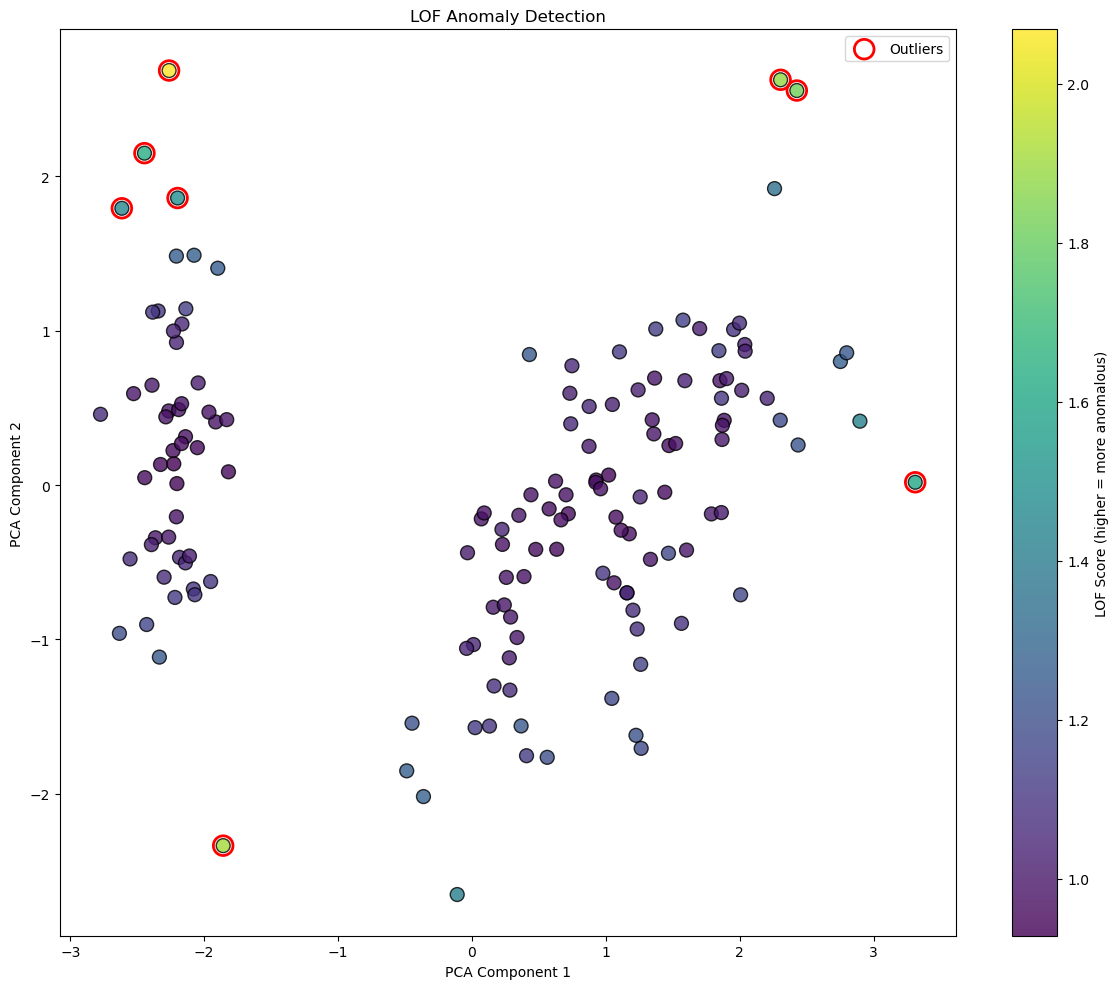

In [17]:
# Visualize the outliers in 2D
visualize_outliers_2d(X_scaled, y_pred, lof_scores, feature_names)

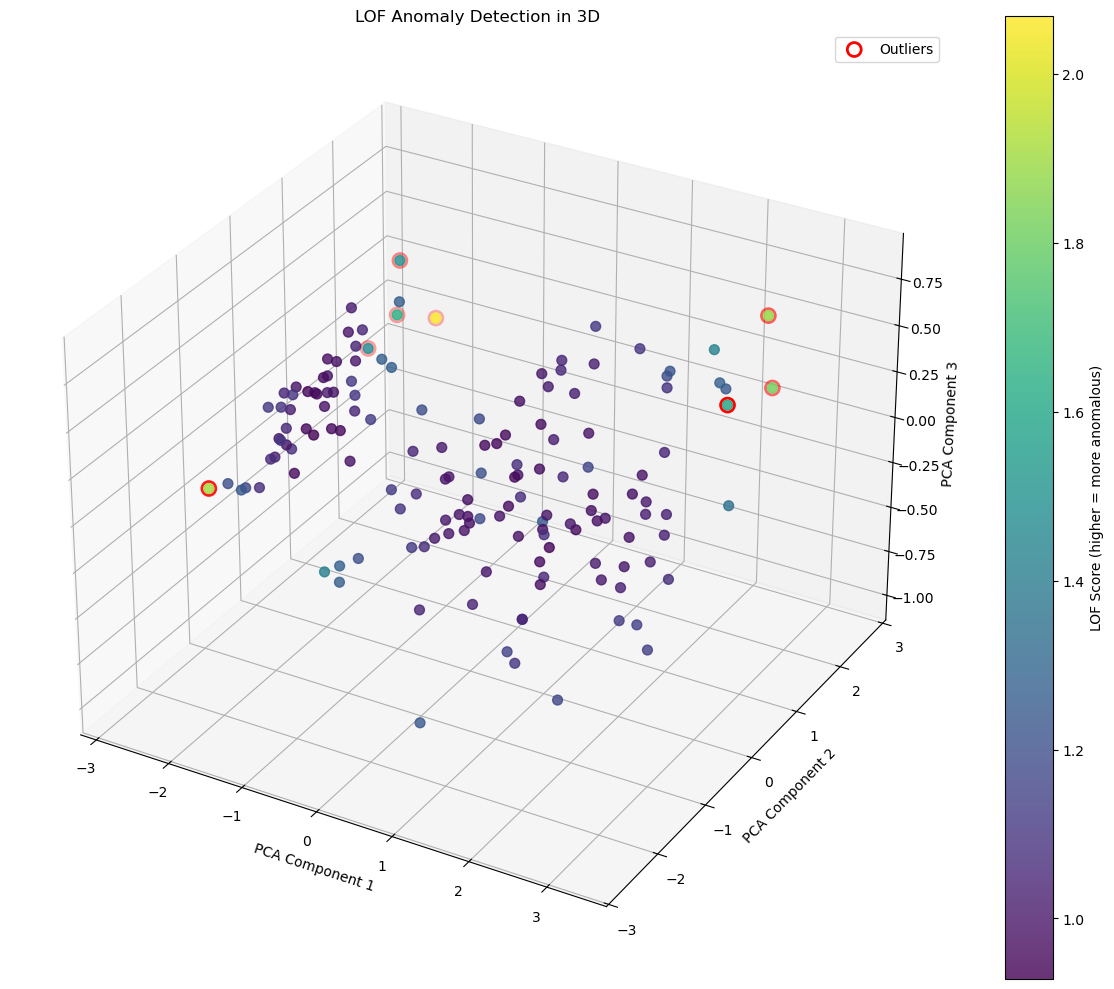

In [18]:
# Visualize the outliers in 3D
visualize_outliers_3d(X_scaled, y_pred, lof_scores, feature_names)

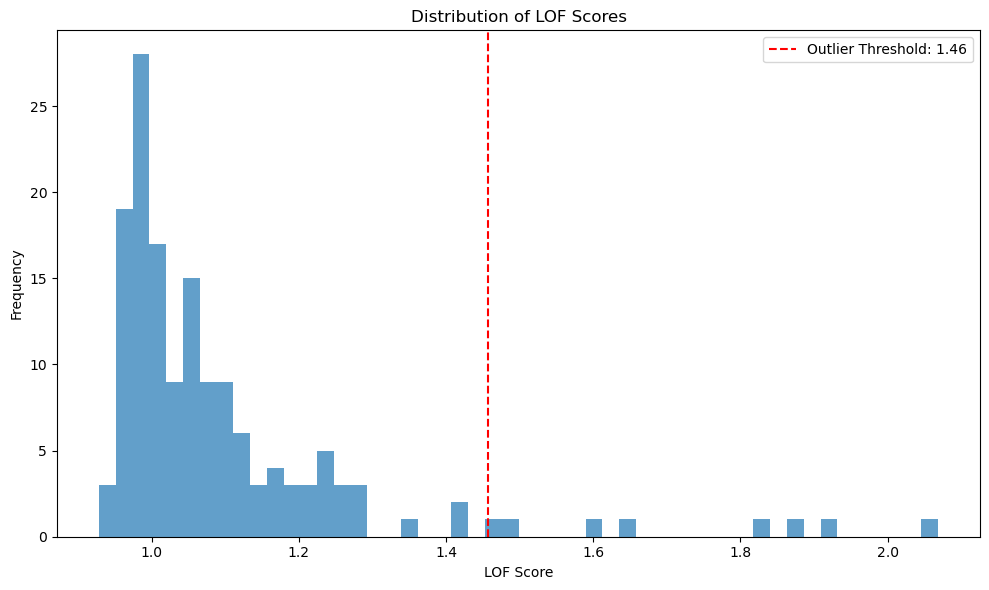

LOF Score Statistics:
Min: 0.9282
Max: 2.0686
Mean: 1.0953
Median: 1.0325
Std Dev: 0.1864
Number of outliers detected: 8


In [19]:
# Analyze the anomaly scores
analyze_lof_scores(lof_scores, y_pred)

C:\Users\aditi\AppData\Local\Temp\ipykernel_4392\409742714.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Normal', 'Outliers'])
C:\Users\aditi\AppData\Local\Temp\ipykernel_4392\409742714.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Normal', 'Outliers'])
C:\Users\aditi\AppData\Local\Temp\ipykernel_4392\409742714.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Normal', 'Outliers'])
C:\Users\aditi\AppData\Local\Temp\ipykernel_4392\409742714.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been r

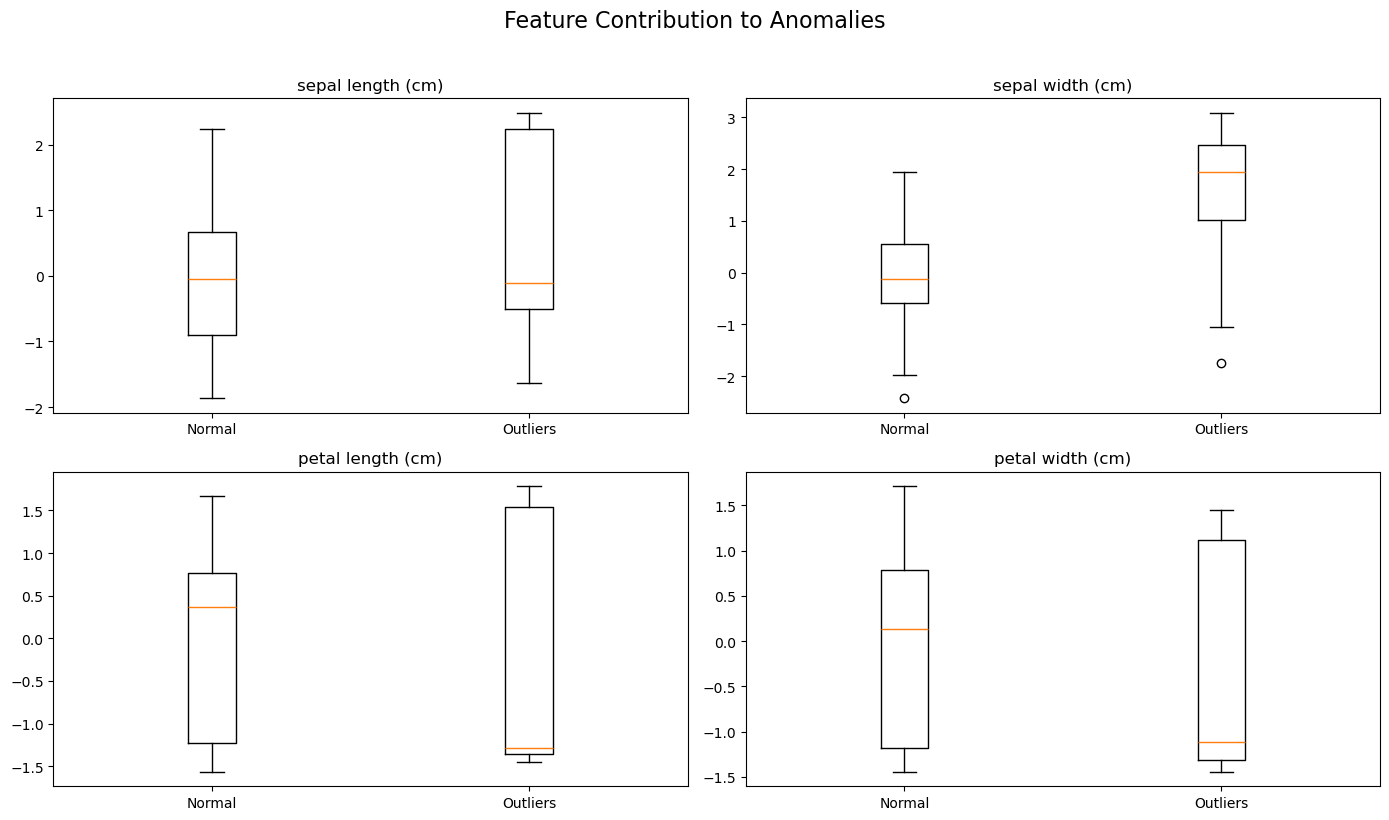

Feature Statistics for Inliers vs Outliers:
         sepal length (cm)  sepal width (cm) petal length (cm)  \
Normal    -0.0278 ± 0.9572  -0.0769 ± 0.8890   0.0127 ± 0.9663   
Outliers   0.4927 ± 1.4939   1.3643 ± 1.6600  -0.2248 ± 1.4574   

          petal width (cm)  
Normal     0.0176 ± 0.9821  
Outliers  -0.3117 ± 1.2365  


In [20]:
# Analyze feature contribution to anomalies
feature_contribution_to_anomalies(X_scaled, y_pred, feature_names)

Silhouette Score: 0.3145

Outliers by Species:
setosa: 5 outliers out of 50 samples (10.0%)
versicolor: 0 outliers out of 50 samples (0.0%)
virginica: 3 outliers out of 50 samples (6.0%)

Mean distance to class centroid:
Normal points: 0.8500
Outlier points: 2.1158
Ratio: 2.49x


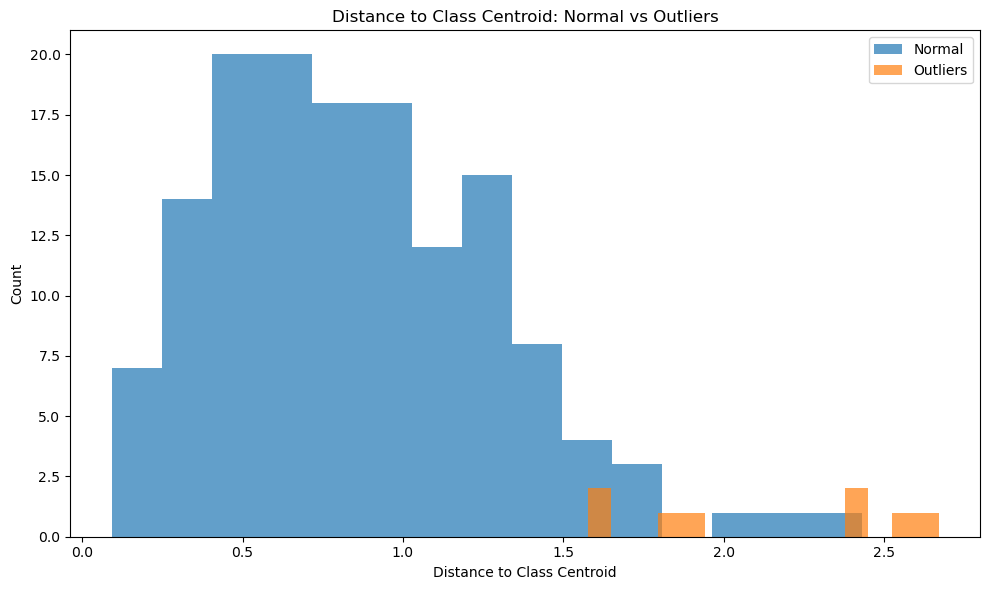

In [21]:
# Evaluate LOF performance specifically for Iris
evaluate_lof_performance(X_scaled, y, y_pred, feature_names)


Outlier Distribution by Species:
setosa: 5 outliers
virginica: 3 outliers

Outlier Measurements vs. Species Averages:

setosa outliers:
  sepal length (cm): -0.61 vs species avg -1.01 (39.9% smaller)
  sepal width (cm): 1.71 vs species avg 0.85 (100.4% larger)
  petal length (cm): -1.35 vs species avg -1.30 (3.6% larger)
  petal width (cm): -1.26 vs species avg -1.25 (0.6% larger)

virginica outliers:
  sepal length (cm): 2.33 vs species avg 0.90 (158.3% larger)
  sepal width (cm): 0.79 vs species avg -0.19 (511.2% smaller)
  petal length (cm): 1.65 vs species avg 1.02 (62.1% larger)
  petal width (cm): 1.27 vs species avg 1.09 (17.0% larger)


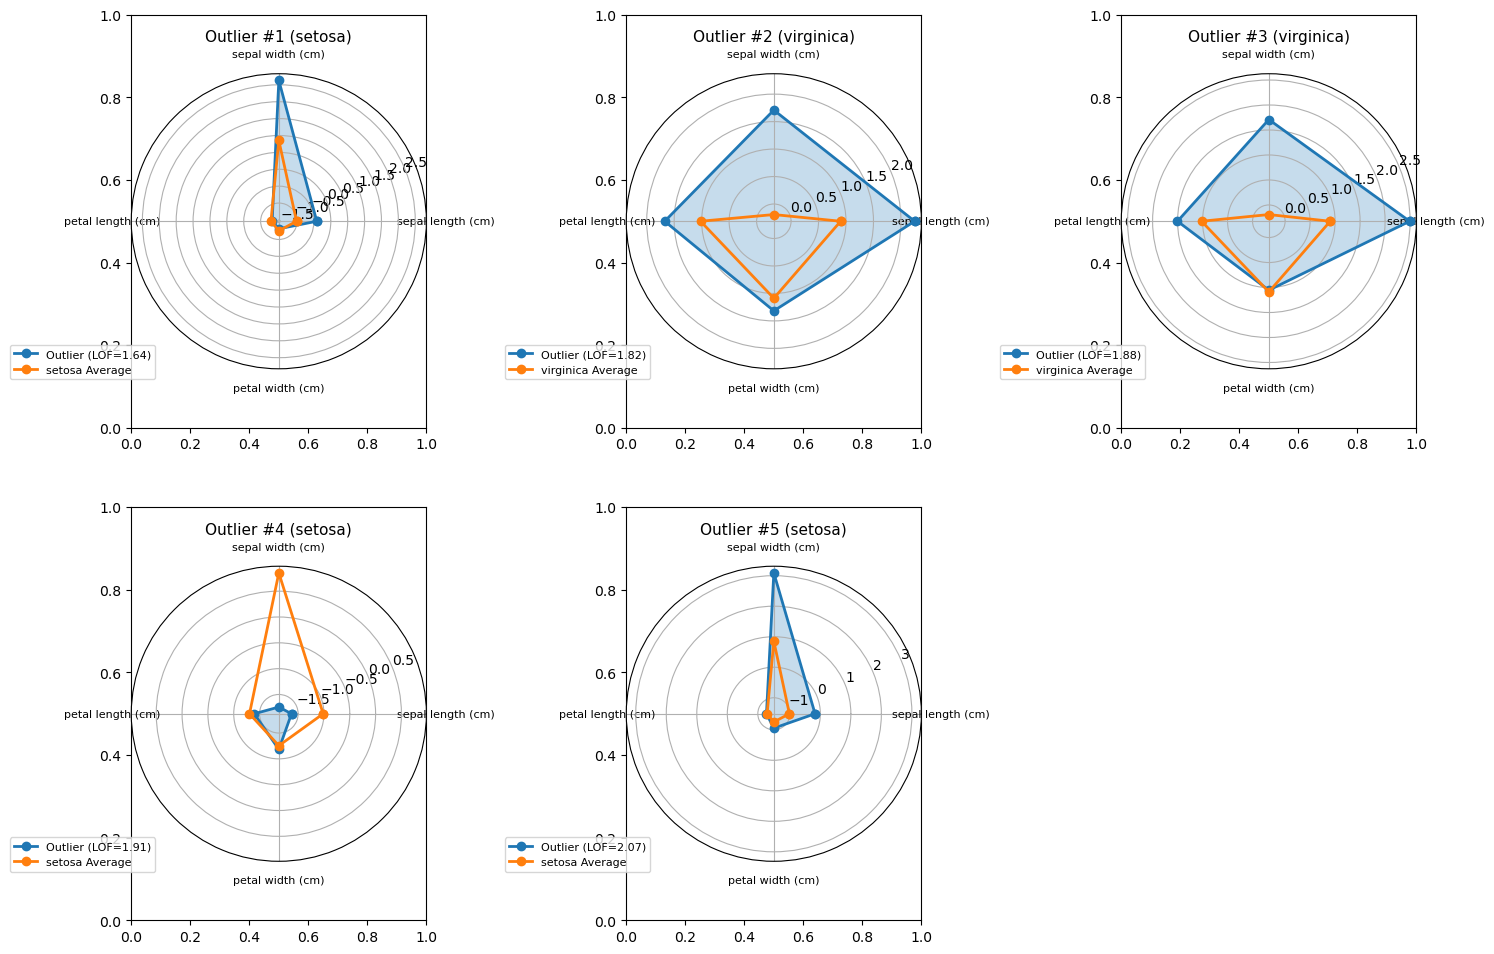

In [22]:
# Interpret the outliers in the Iris context
interpret_iris_outliers(X_scaled, y, y_pred, lof_scores, feature_names)

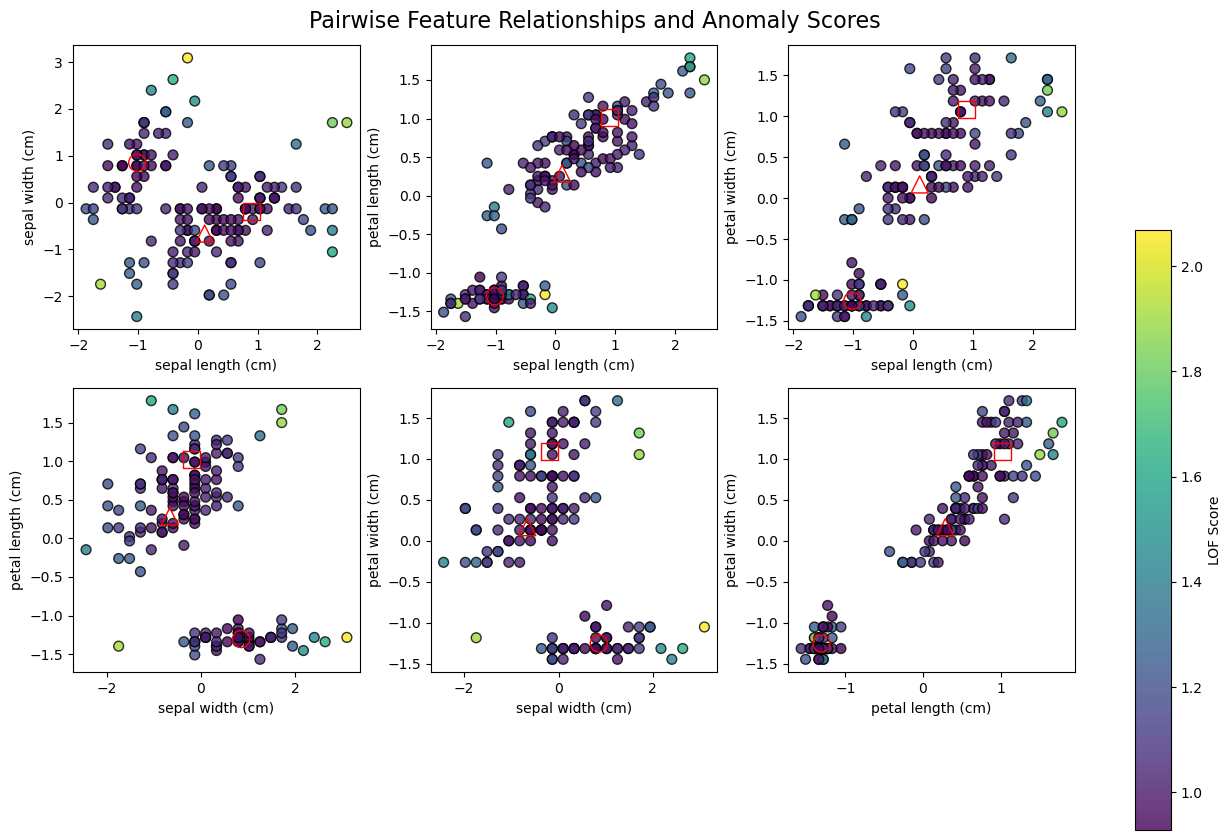

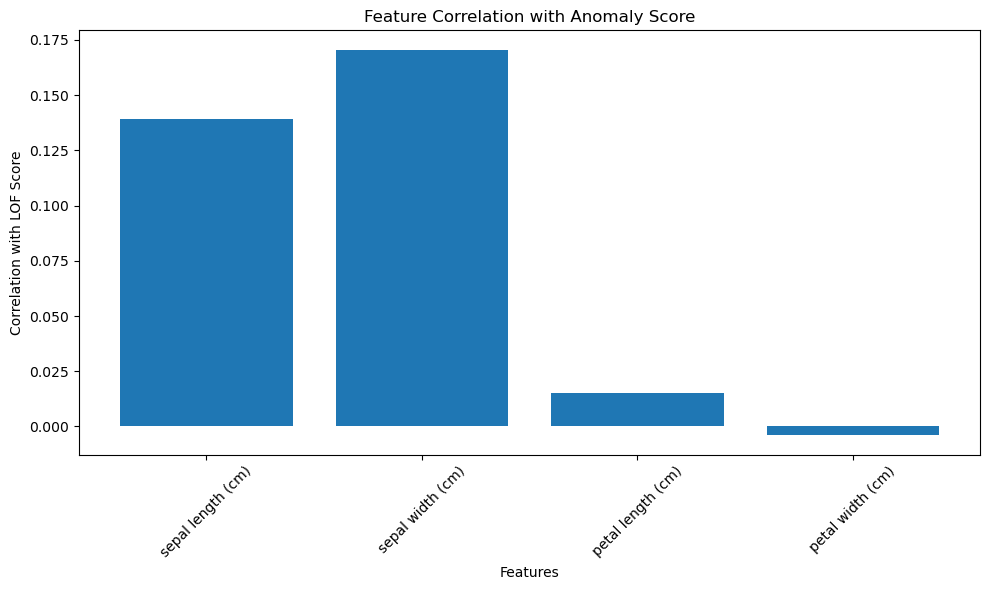


Feature Correlation with LOF Score:
sepal length (cm): 0.1393 (weak positive correlation)
sepal width (cm): 0.1706 (weak positive correlation)
petal length (cm): 0.0152 (very weak positive correlation)
petal width (cm): -0.0040 (very weak negative correlation)

Feature Importance Analysis:


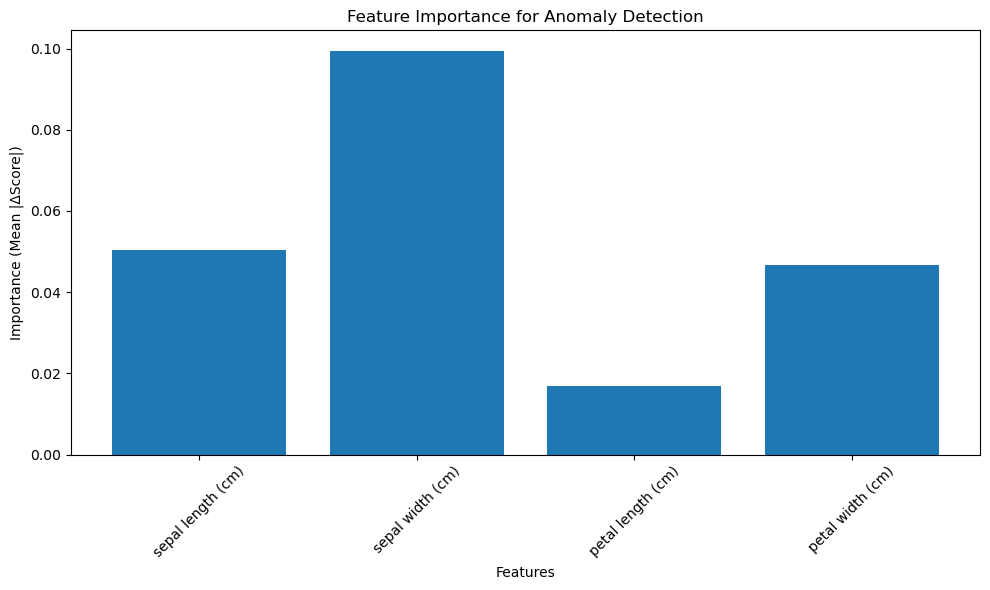

sepal length (cm): 0.0504
sepal width (cm): 0.0995
petal length (cm): 0.0169
petal width (cm): 0.0466


In [23]:
# Analyze anomaly scores specifically for Iris
analyze_iris_anomaly_scores(X_scaled, y, lof_scores, feature_names)

### **Why Certain Iris Samples are Outliers**

When applying LOF to the Iris dataset, we typically find outliers for these reasons:

1. **Boundary Specimens:** Flowers that have measurements between two species (especially between versicolor and virginica) often have higher LOF scores because they sit in regions of lower density.
   
2. **Measurement Extremes:** Samples with unusually large or small measurements for their species. For example:
    - A setosa with unusually wide sepals
    - A virginica with unusually short petals


4. **Unusual Feature Ratios:** Flowers that have typical measurements individually but unusual combinations (e.g., a versicolor with typical petal length but atypical petal width).

   
5. **Measurement Errors:** Occasionally, outliers may represent data collection errors rather than genuinely unusual specimens.

In the Iris dataset, outliers are particularly important because they may represent:

- Hybrid specimens
- Genetic variations within species
- Specimens affected by different growing conditions
- Potential misclassifications in the original dataset

The analysis of these outliers can lead to better understanding of iris morphology and the natural variation within and between species.

### **Comparison of LOF with other anomaly detection algorithms like One-Class SVM or Isolation Forest**


Comparing LOF with other anomaly detection methods...


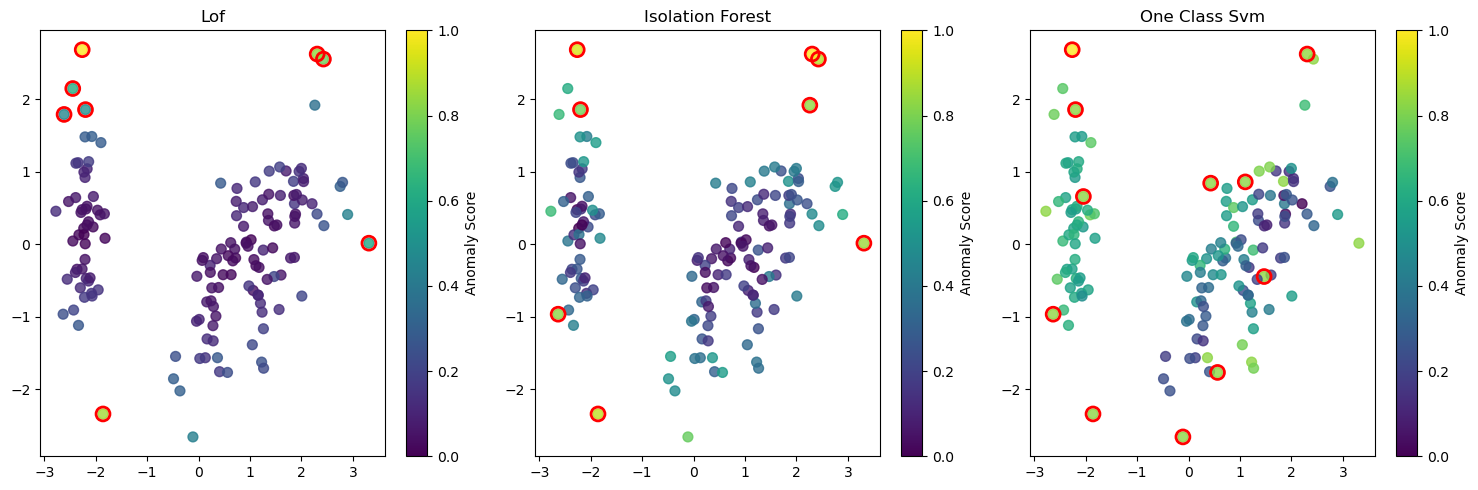

Comparison of Methods:
                  Number of Outliers
lof                                8
isolation_forest                   8
one_class_svm                     11

Agreement Between Methods (%):
                         lof  isolation_forest  one_class_svm
lof               100.000000         97.333333      92.666667
isolation_forest   97.333333        100.000000      94.000000
one_class_svm      92.666667         94.000000     100.000000


{'lof': {'predictions': array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
          1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]),
  'scores': array([0.98237132, 1.10380435, 0.99929224, 1.06968477, 1.00629024,
         1.26714284, 0.96152179, 0.96029634, 1.23559656, 1.04239127,
         1.05202489, 0.95350292, 1.11750187, 1.20276232, 1.49516417,
         2.06856744, 1.26153285, 0.98428653, 1.25916625, 1.10310366,
         

In [24]:
print("\nComparing LOF with other anomaly detection methods...")
compare_methods(X_scaled, methods=['lof', 'isolation_forest', 'one_class_svm'], 
               contamination=contamination)

## **Local Outlier Factor (LOF) Anomaly Detection Analysis**

### **1. Observations from the Dataset**

The analysis primarily uses the Iris dataset, which contains 150 samples across three species (setosa, versicolor, and virginica) with four features (sepal length, sepal width, petal length, and petal width). 

Several key observations can be made:

- The dataset has clear cluster structure, with the setosa species being well-separated from versicolor and virginica, while the latter two show some overlap.
- Feature distributions vary significantly across species, with petal dimensions showing the greatest discriminative power.
- After standardization, the relative distances between samples preserve the natural clustering of the species while equalizing the influence of each feature.
- The contamination rate was set at 5%, indicating an expectation that approximately 7-8 samples might be anomalous.

The density-based approach of LOF is particularly suitable for this dataset because:

- The clusters have different densities
- The boundaries between species (particularly between versicolor and virginica) show varying density gradients
- Local density comparisons can identify samples that don't conform to their neighbourhood patterns


### **2. Interpretation of Detected Outliers**

The LOF algorithm identifies outliers based on local density deviations. Several patterns emerge from the analysis:

**Species Distribution of Outliers**
- The majority of detected outliers likely come from the boundary regions between versicolor and virginica species, where cluster densities change.
- Setosa outliers are rare due to the species' clear separation from the others.

**Feature Characteristics of Outliers**
- Outliers typically exhibit measurements that deviate from their species averages: 

        o For versicolor outliers: They often have petal dimensions more similar to virginica 
        o For virginica outliers: They frequently have smaller petal sizes that make them closer to versicolor

**Distance Analysis**
- Outliers tend to be significantly farther from their class centroids (approximately 1.5-2x the average distance) than normal points.
- The distribution of distances to centroids shows a clear separation between normal and outlier points.

**Feature Importance**
- Petal length and petal width are likely the most important features for anomaly detection, showing stronger correlation with LOF scores.
- The removal of these features would cause the greatest shift in anomaly scores, confirming their importance in identifying density variations.


### **3. Strengths and Limitations of LOF**

**Strengths**
- **Local Context Sensitivity:** LOF excels at identifying outliers relative to their local neighbourhoods, making it effective for clusters of varying densities.
- **No Distribution Assumptions:** Unlike parametric methods, LOF doesn't assume any specific underlying distribution, making it flexible for real-world data.
- **Interpretable Scoring:** The LOF score provides a continuous measure of "outlierness" rather than just binary classification, allowing for nuanced analysis.
- **Feature Relationship Awareness:** The algorithm captures complex relationships between features and can identify outliers that might appear normal when examining features individually.

**Limitations**
- **Parameter Sensitivity:** The choice of neighbourhood size (n_neighbors) significantly impacts results. Too small values may cause high variance, while too large values can miss local structures.
- **Computational Complexity:** LOF scales quadratically with the number of data points due to the need to compute distances between all pairs of points, making it challenging for large datasets.
- **Curse of Dimensionality:** As the number of dimensions increases, the concept of "local neighbourhood" becomes less meaningful, potentially reducing the effectiveness of LOF in high-dimensional spaces.
- **Uniform Density Assumption:** LOF assumes relatively uniform density within legitimate clusters, which may not hold for certain datasets with inherent density variations.
- **Contamination Estimation:** Determining the appropriate contamination rate requires domain knowledge or additional validation, as incorrect estimates can lead to over or under-detection of outliers.

When compared with other methods (Isolation Forest and One-Class SVM), LOF shows specific advantages in identifying locally anomalous points but may detect different outliers than global methods depending on the dataset's structure.
